# Metric Comparison Figures

This notebook generates publication-quality 4×2 grid figures comparing metrics across different modalities.

## Figure Layout
- **Row 1**: Task Performance Features (2 plots) | Physiological Features (1 GSR + 1 ECG)
- **Row 2**: Eye-Tracking Features (2 plots) | Pose Features (2 plots)

Each subplot shows:
- 3 bars for Low, Moderate, High workload conditions
- Error bars (95% CI)
- Significance brackets with stars (*, **, ***)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Import stats utilities
from stats_figures import run_rpy2_lmer, barplot_ax

# Set style
plt.rcParams['font.size'] = 11
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

## Configuration

### Data Paths

In [2]:
# Base directory (parent of stats_utils)
BASE_DIR = Path("..").resolve()

# Data paths
PERFORMANCE_DATA = BASE_DIR / "MATB_performance" / "data" / "processed" / "combined" / "performance_metrics_all.csv"
EYETRACKING_DATA = BASE_DIR / "eye_tracking" / "data" / "processed" / "combined" / "eyegaze_metrics_all.csv"
GSR_DATA = BASE_DIR / "gsr" / "data" / "processed" / "combined" / "gsr_features_all.csv"
ECG_DATA = BASE_DIR / "ecg" / "data" / "processed" / "combined" / "ecg_features_all.csv"

# Pose data - choose normalization method
POSE_METHOD = "procrustes_global"  # Options: "original", "procrustes_global", "procrustes_participant"
POSE_DATA = BASE_DIR / "Pose" / "data" / "processed" / "linear_metrics" / f"{POSE_METHOD}_linear.csv"

print("✓ Data paths configured")

✓ Data paths configured


### Select Metrics to Plot

Choose 2 metrics from each category:

In [3]:
# === CONFIGURE YOUR METRICS HERE ===

# Performance metrics (choose 2)
PERFORMANCE_METRICS = [
    ('average_accuracy', 'Average accuracy (%)'),
    ('average_reaction_time', 'Average reaction time (s)')
]

# Eye-tracking metrics (choose 2)  
EYETRACKING_METRICS = [
    ('blink_rate', 'Blink rate (blinks/min)'),
    ('fix_rate', 'Fixation rate (fix/min)')
]

# Pose metrics (choose 2)
POSE_METRICS = [
    ('head_rotation_rad_rms', 'Head X RMS Rotation (rad)'),
    ('blink_aperture_mean', 'Blink Aperture Mean')
]

# Physiological metrics (1 GSR + 1 ECG)
GSR_METRIC = ('SCR_Peaks_Amplitude_Mean', 'SCR Amplitude (µS)')
ECG_METRIC = ('HRV_MeanNN', 'Heart Rate (bpm)')

print("✓ Metrics configured")
print(f"  Performance: {[m[1] for m in PERFORMANCE_METRICS]}")
print(f"  Eye-tracking: {[m[1] for m in EYETRACKING_METRICS]}")
print(f"  Pose: {[m[1] for m in POSE_METRICS]}")
print(f"  GSR: {GSR_METRIC[1]}")
print(f"  ECG: {ECG_METRIC[1]}")

✓ Metrics configured
  Performance: ['Average accuracy (%)', 'Average reaction time (s)']
  Eye-tracking: ['Blink rate (blinks/min)', 'Fixation rate (fix/min)']
  Pose: ['Head X RMS Rotation (rad)', 'Blink Aperture Mean']
  GSR: SCR Amplitude (µS)
  ECG: Heart Rate (bpm)


## Load and Prepare Data

Load all datasets and add necessary columns:

In [4]:
def prepare_dataframe(df, participant_col="participant"):
    """
    Add required columns to dataframe for mixed-effects modeling.
    
    The dataframe should already have:
    - participant_id (or participant)
    - condition (L, M, H)
    - window_index
    
    Optionally adds session_order_numeric if not present (defaults to 1).
    """
    df = df.copy()
    
    # Rename participant column if needed
    if participant_col in df.columns and participant_col != "participant_id":
        df = df.rename(columns={participant_col: "participant_id"})
    
    # Ensure condition is uppercase
    if "condition" in df.columns:
        df["condition"] = df["condition"].astype(str).str.strip().str.upper()
    
    # Add session_order_numeric if not present (used as covariate in mixed-effects model)
    if "session_order_numeric" not in df.columns:
        print(f"  Note: session_order_numeric not found, using default value of 1")
        df["session_order_numeric"] = 1
    
    return df


# Load all datasets
print("Loading datasets...")
performance_df = pd.read_csv(PERFORMANCE_DATA)
print(f"  ✓ Performance: {performance_df.shape[0]} rows")

eyetracking_df = pd.read_csv(EYETRACKING_DATA)
print(f"  ✓ Eye-tracking: {eyetracking_df.shape[0]} rows")

gsr_df = pd.read_csv(GSR_DATA)
print(f"  ✓ GSR: {gsr_df.shape[0]} rows")

ecg_df = pd.read_csv(ECG_DATA)
print(f"  ✓ ECG: {ecg_df.shape[0]} rows")

pose_df = pd.read_csv(POSE_DATA)
print(f"  ✓ Pose ({POSE_METHOD}): {pose_df.shape[0]} rows")

# Prepare all dataframes
print("\nPreparing dataframes...")
performance_df = prepare_dataframe(performance_df, participant_col="participant")
eyetracking_df = prepare_dataframe(eyetracking_df, participant_col="participant")
gsr_df = prepare_dataframe(gsr_df, participant_col="participant")
ecg_df = prepare_dataframe(ecg_df, participant_col="participant")
pose_df = prepare_dataframe(pose_df, participant_col="participant")

print("✓ All data loaded and prepared")

Loading datasets...
  ✓ Performance: 1935 rows
  ✓ Eye-tracking: 1875 rows
  ✓ GSR: 1782 rows
  ✓ ECG: 1681 rows
  ✓ Pose (procrustes_global): 2021 rows

Preparing dataframes...
  Note: session_order_numeric not found, using default value of 1
  Note: session_order_numeric not found, using default value of 1
  Note: session_order_numeric not found, using default value of 1
  Note: session_order_numeric not found, using default value of 1
  Note: session_order_numeric not found, using default value of 1
✓ All data loaded and prepared


## Run Statistical Analysis

Perform mixed-effects modeling for all selected metrics:

In [5]:
def analyze_metric(df, metric_col, metric_label):
    """
    Run statistical analysis for a single metric.
    
    Returns:
        dict with 'pvals', 'means', 'cis', 'label'
    """
    print(f"\nAnalyzing: {metric_label}")
    
    try:
        pvals, means, cis = run_rpy2_lmer(df, metric_col, metric_label)
        
        return {
            'pvals': pvals,
            'means': means,
            'cis': cis,
            'label': metric_label
        }
    except Exception as e:
        print(f"  ✗ Error analyzing {metric_label}: {e}")
        return None


# Analyze all metrics
results = {}

print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
results['performance'] = []
for metric_col, metric_label in PERFORMANCE_METRICS:
    result = analyze_metric(performance_df, metric_col, metric_label)
    if result:
        results['performance'].append(result)

print("\n" + "=" * 60)
print("EYE-TRACKING METRICS")
print("=" * 60)
results['eyetracking'] = []
for metric_col, metric_label in EYETRACKING_METRICS:
    result = analyze_metric(eyetracking_df, metric_col, metric_label)
    if result:
        results['eyetracking'].append(result)

print("\n" + "=" * 60)
print("POSE METRICS")
print("=" * 60)
results['pose'] = []
for metric_col, metric_label in POSE_METRICS:
    result = analyze_metric(pose_df, metric_col, metric_label)
    if result:
        results['pose'].append(result)

print("\n" + "=" * 60)
print("GSR METRIC")
print("=" * 60)
result = analyze_metric(gsr_df, GSR_METRIC[0], GSR_METRIC[1])
results['gsr'] = [result] if result else []

print("\n" + "=" * 60)
print("ECG METRIC")
print("=" * 60)
result = analyze_metric(ecg_df, ECG_METRIC[0], ECG_METRIC[1])
results['ecg'] = [result] if result else []

print("\n" + "=" * 60)
print("✓ Statistical analysis complete")
print("=" * 60)

R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  


PERFORMANCE METRICS

Analyzing: Average accuracy (%)
Means for average_accuracy:
  H: 59.713
  L: 83.455
  M: 77.142


R callback write-console: 
Attaching package: ‘lmerTest’

  
R callback write-console: The following object is masked from ‘package:lme4’:

    lmer

  
R callback write-console: The following object is masked from ‘package:stats’:

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



=== Average accuracy (%) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 14196.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4719 -0.6490  0.0526  0.6822  2.7093 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 118.8    10.898  
 Residual                    82.0     9.055  
Number of obs: 1935, groups:  participant_id, 43

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    75.31780    1.70755   45.39632   44.11  < 2e-16 ***
condition.L   -16.78768    0.35655 1889.00000  -47.08  < 2e-16 ***
condition.Q    -4.53842    0.35655 1889.00000  -12.73  < 2e-16 ***
window_index   -0.26874    0.04765 1889.00000   -5.64 1.96e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

C

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Pairwise comparisons for 'condition':
 contrast estimate    SE   df t.ratio p.value
 L - M        6.31 0.504 1889  12.518  <.0001
 L - H       23.74 0.504 1889  47.083  <.0001
 M - H       17.43 0.504 1889  34.565  <.0001

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


Analyzing: Average reaction time (s)
Means for average_reaction_time:
  H: 2.802
  L: 2.234
  M: 2.941

=== Average reaction time (s) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 8633.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3911 -0.7739 -0.3352  0.6396  4.2809 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1231   0.3509  
 Residual                   4.9572   2.2265  
Number of obs: 1935, g

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Pairwise comparisons for 'condition':
 contrast estimate    SE   df t.ratio p.value
 L - M      -0.707 0.124 1889  -5.705  <.0001
 L - H      -0.568 0.124 1889  -4.583  <.0001
 M - H       0.139 0.124 1889   1.123  0.5002

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


EYE-TRACKING METRICS

Analyzing: Blink rate (blinks/min)
Means for blink_rate:
  H: 0.666
  L: 0.485
  M: 0.566


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



=== Blink rate (blinks/min) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1479.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0611 -0.4794 -0.1208  0.2933 13.4891 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.05911  0.2431  
 Residual                   0.11838  0.3441  
Number of obs: 1875, groups:  participant_id, 43

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  5.603e-01  4.008e-02 5.243e+01  13.981   <2e-16 ***
condition.L  1.245e-01  1.382e-02 1.831e+03   9.006   <2e-16 ***
condition.Q  6.429e-03  1.380e-02 1.830e+03   0.466    0.641    
window_index 2.168e-03  1.849e-03 1.829e+03   1.173    0.241    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



POSE METRICS

Analyzing: Head X RMS Rotation (rad)
Means for head_rotation_rad_rms:
  H: 0.064
  L: 0.061
  M: 0.068

=== Head X RMS Rotation (rad) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9066.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2359 -0.3940 -0.0609  0.3322 14.4818 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0012602 0.03550 
 Residual                   0.0005823 0.02413 
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   6.157e-02  5.390e-03  4.638e+01  11.423 4.45e-15 ***
condition.L   1.775e-03  9.303e-04  1.973e+03   1.908 0.056510 .  
condition.Q  -4.936e-03  9.293e-04  1.973e+03  -5.311 1.21e-07 ***
window_ind

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Analyzing: Blink Aperture Mean
Means for blink_aperture_mean:
  H: 0.141
  L: 0.143
  M: 0.143

=== Blink Aperture Mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13790.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0654 -0.6595 -0.0028  0.6242  3.8811 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 5.874e-04 0.024235
 Residual                   5.347e-05 0.007313
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.405e-01  3.626e-03  4.447e+01  38.756  < 2e-16 ***
condition.L  -2.136e-03  2.823e-04  1.970e+03  -7.569 5.73e-14 ***
condition.Q  -7.138e-04  2.817e-04  1.970e+03  -2.534   0.0114 *  
window_index  2.627e-04  3.772e-05  1

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



GSR METRIC

Analyzing: SCR Amplitude (µS)
Means for SCR_Peaks_Amplitude_Mean:
  H: 0.286
  L: 0.214
  M: 0.309

=== SCR Amplitude (µS) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -2081.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1469 -0.4564 -0.0825  0.4133  7.7405 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.06100  0.2470  
 Residual                   0.01595  0.1263  
Number of obs: 1782, groups:  participant_id, 40

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.529e-01  3.946e-02  4.019e+01   6.409 1.23e-07 ***
condition.L   5.145e-02  5.192e-03  1.739e+03   9.910  < 2e-16 ***
condition.Q  -4.889e-02  5.180e-03  1.739e+03  -9.438  < 2e-16 ***
window_index  2.182e-03  6

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



=== Heart Rate (bpm) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19094.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5032 -0.2231 -0.0097  0.2007 11.6180 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 14827    121.8   
 Residual                    4569     67.6   
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  7.254e+02  2.000e+01 3.794e+01  36.266  < 2e-16 ***
condition.L  1.816e+01  2.869e+00 1.639e+03   6.330 3.17e-10 ***
condition.Q  8.965e-02  2.869e+00 1.639e+03   0.031    0.975    
window_index 8.219e-03  3.817e-01 1.639e+03   0.022    0.983    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of 

## Generate 4×2 Grid Figure

Create the publication-quality figure:


✓ Figure saved to: figures/metric_comparison_figure.png


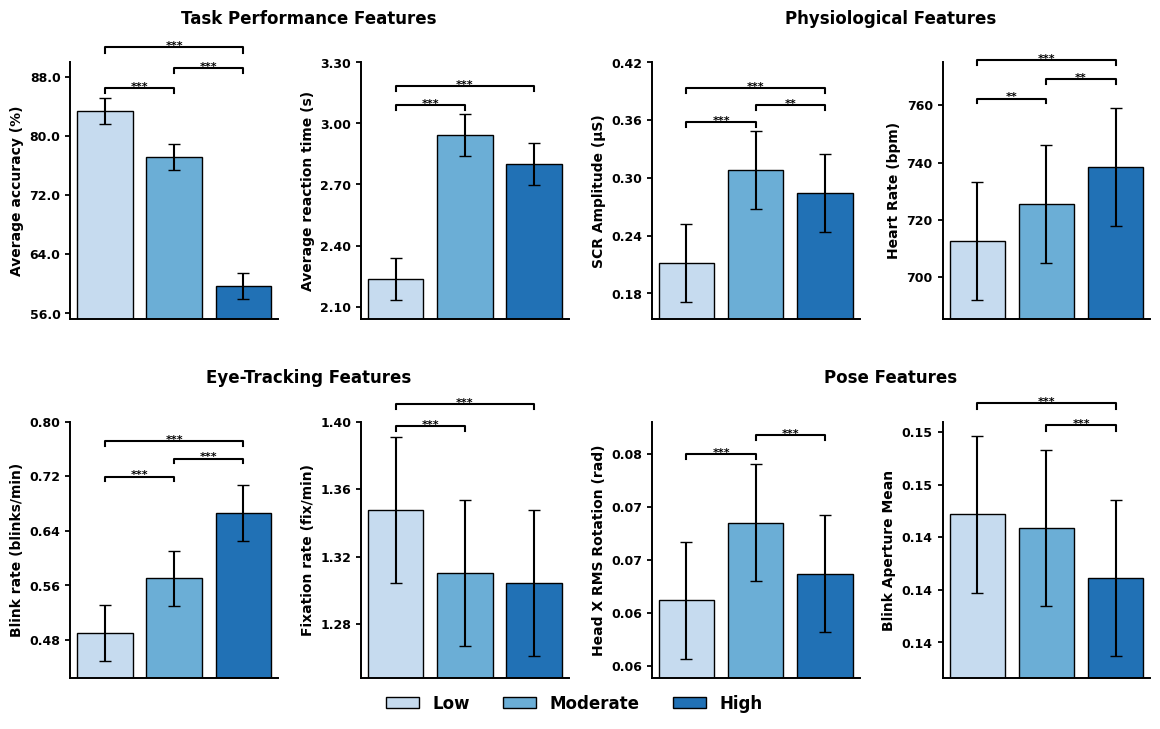

In [6]:
def plot_metric_grid(results, figsize=(12, 10), save_path=None):
    """
    Create 4×2 grid of metric comparison plots.
    
    Layout:
    - Row 1: Performance (2) | Physiology (GSR + ECG)
    - Row 2: Eye-tracking (2) | Pose (2)
    """
    fig = plt.figure(figsize=figsize)
    
    # Create grid: 2 rows, 4 columns
    gs = fig.add_gridspec(2, 4, hspace=0.4, wspace=0.4,
                          top=0.94, bottom=0.06, left=0.08, right=0.98)
    
    # Color scheme (matching reference figure)
    colors = ['#c6dbef', '#6baed6', '#2171b5']  # Light, medium, dark blue
    
    # --- Row 1, Left: Performance Features ---
    if len(results.get('performance', [])) >= 2:
        for i, res in enumerate(results['performance'][:2]):
            ax = fig.add_subplot(gs[0, i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list, 
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Add group title centered over both plots
            if i == 0:
                ax.text(1.15, 1.15, 'Task Performance Features',
                       transform=ax.transAxes, fontsize=12,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis to end at top tick mark
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                # Keep bottom as is, set top to highest visible tick
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 1, Right: Physiological Features (GSR + ECG) ---
    physio_results = results.get('gsr', []) + results.get('ecg', [])
    if len(physio_results) >= 2:
        for i, res in enumerate(physio_results[:2]):
            ax = fig.add_subplot(gs[0, 2 + i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Add group title centered over both plots
            if i == 0:
                ax.text(1.15, 1.15, 'Physiological Features',
                       transform=ax.transAxes, fontsize=12,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis to end at top tick mark
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                # Keep bottom as is, set top to highest visible tick
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 2, Left: Eye-Tracking Features ---
    if len(results.get('eyetracking', [])) >= 2:
        for i, res in enumerate(results['eyetracking'][:2]):
            ax = fig.add_subplot(gs[1, i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Add group title centered over both plots
            if i == 0:
                ax.text(1.15, 1.15, 'Eye-Tracking Features',
                       transform=ax.transAxes, fontsize=12,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis to end at top tick mark
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                # Keep bottom as is, set top to highest visible tick
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 2, Right: Pose Features ---
    if len(results.get('pose', [])) >= 2:
        for i, res in enumerate(results['pose'][:2]):
            ax = fig.add_subplot(gs[1, 2 + i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Add group title centered over both plots
            if i == 0:
                ax.text(1.15, 1.15, 'Pose Features',
                       transform=ax.transAxes, fontsize=12,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis to end at top tick mark
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                # Keep bottom as is, set top to highest visible tick
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # Add legend at bottom
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Low'),
        Patch(facecolor=colors[1], edgecolor='black', label='Moderate'),
        Patch(facecolor=colors[2], edgecolor='black', label='High')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3,
              frameon=False, fontsize=12, bbox_to_anchor=(0.5, -0.01))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Figure saved to: {save_path}")
    
    return fig


# Generate the figure
fig = plot_metric_grid(
    results,
    figsize=(12, 7),
    save_path='figures/metric_comparison_figure.png'
)

plt.show()

## Available Metrics Reference

For easy reference, here are some common metrics from each modality:

In [7]:
print("=" * 60)
print("AVAILABLE METRICS")
print("=" * 60)

print("\n--- Performance Metrics ---")
perf_cols = [c for c in performance_df.columns if c not in ['participant_id', 'condition', 'window_index', 'start_time', 'end_time', 'session_order_numeric']]
for col in sorted(perf_cols)[:15]:
    print(f"  - {col}")

print("\n--- Eye-Tracking Metrics ---")
eye_cols = [c for c in eyetracking_df.columns if c not in ['participant_id', 'condition', 'window_index', 'start_time', 'end_time', 'session_order_numeric']]
for col in sorted(eye_cols)[:15]:
    print(f"  - {col}")

print("\n--- Pose Metrics (sample) ---")
pose_cols = [c for c in pose_df.columns if 'rms' in c.lower()]
for col in sorted(pose_cols)[:15]:
    print(f"  - {col}")

print("\n--- GSR Metrics ---")
gsr_cols = [c for c in gsr_df.columns if c not in ['participant_id', 'condition', 'window_index', 't_start_sec', 't_end_sec', 'filename', 'session_order_numeric']]
for col in sorted(gsr_cols):
    print(f"  - {col}")

print("\n--- ECG Metrics (sample) ---")
ecg_cols = [c for c in ecg_df.columns if c.startswith('HRV')]
for col in sorted(ecg_cols)[:15]:
    print(f"  - {col}")

print("\n" + "=" * 60)

AVAILABLE METRICS

--- Performance Metrics ---
  - average_accuracy
  - average_reaction_time
  - comms_average_reaction_times
  - comms_events
  - comms_failure_rate
  - comms_own_events
  - resman_failure_rate
  - sysmon_average_reaction_times
  - sysmon_failure_rate
  - track_failure_rate

--- Eye-Tracking Metrics ---
  - blink_count
  - blink_mean_dur
  - blink_rate
  - fix_count
  - fix_mean_dur
  - fix_rate
  - max_vel
  - mean_acc
  - mean_vel
  - pct_missing
  - rms_disp
  - sac_count
  - sac_mean_dur
  - sac_rate

--- Pose Metrics (sample) ---
  - blink_aperture_acc_rms
  - blink_aperture_rms
  - blink_aperture_vel_rms
  - head_motion_mag_acc_rms
  - head_motion_mag_rms
  - head_motion_mag_vel_rms
  - head_rotation_rad_acc_rms
  - head_rotation_rad_rms
  - head_rotation_rad_vel_rms
  - head_scalex_acc_rms
  - head_scalex_rms
  - head_scalex_vel_rms
  - head_scaley_acc_rms
  - head_scaley_rms
  - head_scaley_vel_rms

--- GSR Metrics ---
  - EDA_Autocorrelation
  - EDA_Tonic_SD


## Combined Figure for Paper

Combined figure showing task setup image above the 4×2 metric comparison grid.
Formatted for letter-size page (8.5" width) with 10% margins.


✓ Combined paper figure saved to: figures/metric_comparison_paper_figure.png


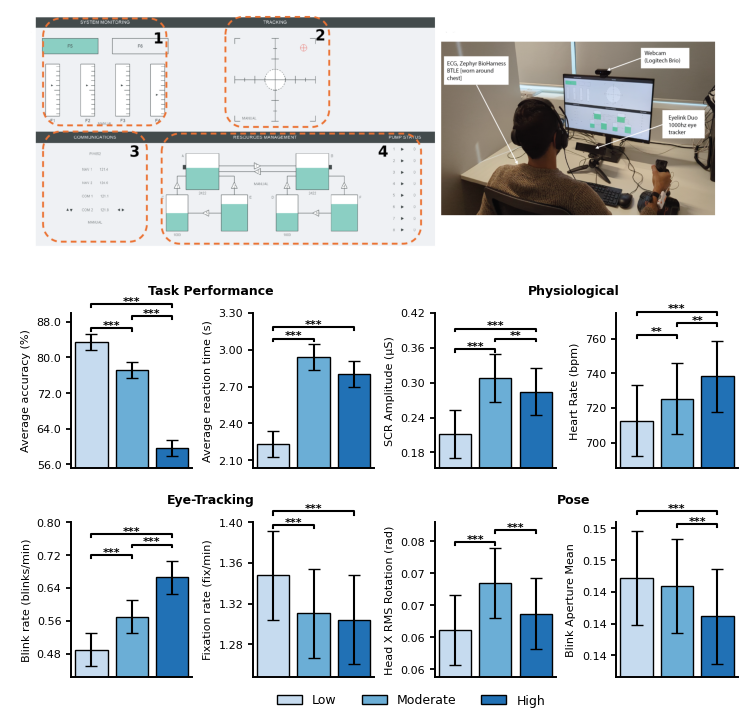

In [8]:
def plot_combined_paper_figure(results, task_image_path, figsize=None, save_path=None):
    """
    Create combined figure with task setup image above 4×2 metric grid.
    
    Layout:
    - Top: Task setup image (spanning width of plots)
    - Bottom: 4×2 grid of metric comparisons
    
    Args:
        results: Dictionary with analysis results
        task_image_path: Path to task setup image
        figsize: Figure size (auto-calculated for letter page if None)
        save_path: Path to save figure
    """
    from PIL import Image
    
    # Letter page width with 10% margins on each side
    page_width = 8.5 * 0.8  # 6.8 inches usable width
    
    # Increase height slightly for less squishing
    if figsize is None:
        total_height = 7.5  # Increased from 6.5 for more breathing room
        figsize = (page_width, total_height)
    
    # Temporarily override font settings to remove bold
    import matplotlib
    original_weight = matplotlib.rcParams['font.weight']
    original_axes_weight = matplotlib.rcParams['axes.labelweight']
    matplotlib.rcParams['font.weight'] = 'normal'
    matplotlib.rcParams['axes.labelweight'] = 'normal'
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create main grid: 2 rows (image top, plots bottom)
    # Minimal margins to eliminate white space
    main_gs = fig.add_gridspec(2, 1, height_ratios=[0.4, 0.6], 
                               hspace=0.2,
                               top=0.97, bottom=0.08, left=0.0, right=0.98)  # Set left=0.0
    
    # --- Top: Task Setup Image ---
    ax_image = fig.add_subplot(main_gs[0])
    
    # Load image, draw it to fill the top axes and span the full figure width,
    # keeping axis off so it's centered visually with no ticks/frames.
    img = Image.open(task_image_path)
    ax_image.imshow(img, aspect='auto', extent=[0, 1, 0, 1])
    ax_image.set_xlim(0, 1)
    ax_image.set_ylim(0, 1)
    ax_image.axis('off')

    # Make the axes occupy the full horizontal space of the main gridspec (respecting right=0.98)
    pos = main_gs[0].get_position(fig)
    left_margin = -.09
    right_margin = 0.96
    ax_image.set_position([left_margin, pos.y0, right_margin - left_margin, pos.height])
    
    # --- Bottom: 4×2 Metric Grid ---
    # Create sub-gridspec for the 4×2 plot grid
    # Reduce hspace to reduce vertical gap between rows
    plot_gs = main_gs[1].subgridspec(2, 4, hspace=0.35, wspace=0.5)
    
    # Color scheme (matching reference figure)
    colors = ['#c6dbef', '#6baed6', '#2171b5']  # Light, medium, dark blue
    
    # --- Row 1, Left: Performance Features ---
    if len(results.get('performance', [])) >= 2:
        for i, res in enumerate(results['performance'][:2]):
            ax = fig.add_subplot(plot_gs[0, i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list, 
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Set font sizes and weights explicitly
            ax.set_ylabel(res['label'], fontsize=8, fontweight='normal')
            ax.tick_params(axis='both', labelsize=8)
            # Override bold tick labels from barplot_ax
            for label in ax.get_yticklabels():
                label.set_fontweight('normal')
                label.set_fontsize(8)
            
            # Add group title
            if i == 0:
                ax.text(1.15, 1.12, 'Task Performance',
                       transform=ax.transAxes, fontsize=9,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis to end at top tick
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 1, Right: Physiological Features (GSR + ECG) ---
    physio_results = results.get('gsr', []) + results.get('ecg', [])
    if len(physio_results) >= 2:
        for i, res in enumerate(physio_results[:2]):
            ax = fig.add_subplot(plot_gs[0, 2 + i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Set font sizes and weights
            ax.set_ylabel(res['label'], fontsize=8, fontweight='normal')
            ax.tick_params(axis='both', labelsize=8)
            # Override bold tick labels from barplot_ax
            for label in ax.get_yticklabels():
                label.set_fontweight('normal')
                label.set_fontsize(8)
            
            # Add group title
            if i == 0:
                ax.text(1.15, 1.12, 'Physiological',
                       transform=ax.transAxes, fontsize=9,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 2, Left: Eye-Tracking Features ---
    if len(results.get('eyetracking', [])) >= 2:
        for i, res in enumerate(results['eyetracking'][:2]):
            ax = fig.add_subplot(plot_gs[1, i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Set font sizes and weights
            ax.set_ylabel(res['label'], fontsize=8, fontweight='normal')
            ax.tick_params(axis='both', labelsize=8)
            # Override bold tick labels from barplot_ax
            for label in ax.get_yticklabels():
                label.set_fontweight('normal')
                label.set_fontsize(8)
            
            # Add group title
            if i == 0:
                ax.text(1.15, 1.12, 'Eye-Tracking',
                       transform=ax.transAxes, fontsize=9,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # --- Row 2, Right: Pose Features ---
    if len(results.get('pose', [])) >= 2:
        for i, res in enumerate(results['pose'][:2]):
            ax = fig.add_subplot(plot_gs[1, 2 + i])
            
            conds = ['L', 'M', 'H']
            mean_vals = [res['means'].get(c, float('nan')) for c in conds]
            sems = [(res['cis'][c][1] - res['cis'][c][0]) / 3.92 if c in res['cis'] else float('nan') for c in conds]
            pval_list = [
                res['pvals'].get(('L', 'M'), 1.0),
                res['pvals'].get(('L', 'H'), 1.0),
                res['pvals'].get(('M', 'H'), 1.0)
            ]
            
            barplot_ax(ax, mean_vals, sems, pval_list,
                      ylabel=res['label'], metric_name=res['label'],
                      colors=colors)
            
            # Set font sizes and weights
            ax.set_ylabel(res['label'], fontsize=8, fontweight='normal')
            ax.tick_params(axis='both', labelsize=8)
            # Override bold tick labels from barplot_ax
            for label in ax.get_yticklabels():
                label.set_fontweight('normal')
                label.set_fontsize(8)
            
            # Add group title
            if i == 0:
                ax.text(1.15, 1.12, 'Pose',
                       transform=ax.transAxes, fontsize=9,
                       fontweight='bold', ha='center')
            
            # Adjust y-axis
            yticks = ax.get_yticks()
            ymin, ymax = ax.get_ylim()
            if len(yticks) > 0:
                visible_ticks = [t for t in yticks if t >= ymin and t <= ymax]
                if visible_ticks:
                    ax.set_ylim(ymin, max(visible_ticks))
    
    # Add legend at bottom
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Low'),
        Patch(facecolor=colors[1], edgecolor='black', label='Moderate'),
        Patch(facecolor=colors[2], edgecolor='black', label='High')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3,
              frameon=False, fontsize=9, bbox_to_anchor=(0.5, 0.025))
    
    # Restore original font settings
    matplotlib.rcParams['font.weight'] = original_weight
    matplotlib.rcParams['axes.labelweight'] = original_axes_weight
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Combined paper figure saved to: {save_path}")
    
    return fig


# Generate the combined paper figure
task_image_path = BASE_DIR / "media" / "task_setup.png"

fig = plot_combined_paper_figure(
    results,
    task_image_path=task_image_path,
    save_path='figures/metric_comparison_paper_figure.png'
)

plt.show()